In [1]:
from src.net import EventBERTMLM
from config import config
import torch
from torchinfo import summary

In [3]:
print("--- 初始化配置 ---")

print("--- 实例化 Backbone 模型 ---")
model = EventBERTMLM(config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("\n--- 准备模拟输入数据 ---")
batch_size = 1
seq_len = config.max_seq_len # 确保 seq_len <= config.max_seq_len
input_channels = 3
input_height = 200
input_width = 200

# 模拟正负事件图像序列
# (batch_size, seq_len, C, H, W)
mock_x_pos = torch.randn(batch_size, seq_len, input_channels, input_height, input_width).to(device)
mock_x_neg = torch.randn(batch_size, seq_len, input_channels, input_height, input_width).to(device)

print(f"模拟输入 x_pos 形状: {mock_x_pos.shape}")
print(f"模拟输入 x_neg 形状: {mock_x_neg.shape}")

print("\n--- 执行模型前向传播 ---")
summary(model, input_data=[mock_x_pos, mock_x_neg, 0.15], verbose=1)

print("\n--- 测试完成 ---")


--- 初始化配置 ---
--- 实例化 Backbone 模型 ---

--- 准备模拟输入数据 ---
模拟输入 x_pos 形状: torch.Size([1, 16, 3, 200, 200])
模拟输入 x_neg 形状: torch.Size([1, 16, 3, 200, 200])

--- 执行模型前向传播 ---
Layer (type:depth-idx)                                       Output Shape              Param #
EventBERTMLM                                                 [1, 2, 3, 200, 200]       768
├─EventImg2Token: 1-1                                        [1, 144, 768]             --
│    └─Sequential: 2-1                                       [16, 1024, 13, 13]        --
│    │    └─ConvDw: 3-1                                      [16, 32, 100, 100]        193
│    │    └─ConvDw: 3-2                                      [16, 128, 50, 50]         4,704
│    │    └─ConvDw: 3-3                                      [16, 512, 25, 25]         67,968
│    │    └─ConvDw: 3-4                                      [16, 1024, 13, 13]        531,968
│    └─Sequential: 2-2                                       [16, 1024, 13, 13]        --
│

In [ ]:
del model
del mock_x_pos
del mock_x_neg 
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from transformers import ModernBertModel, ModernBertConfig

# Initializing a ModernBert style configuration
configuration = ModernBertConfig()

# Initializing a model from the modernbert-base style configuration
model = ModernBertModel(configuration)

# Accessing the model configuration
configuration = model.config

In [ ]:
print(model)

In [ ]:
print(torch.randperm(10)[:4])

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import glob # 用于文件路径匹配

class EventSequenceDataset(Dataset):
    def __init__(self, root_dir, seq_len=20, transform=None):
        """
        Args:
            root_dir (string): 包含所有序列文件夹的根目录 (e.g., 'train/').
            seq_len (int): 每个样本的序列长度。
            transform (callable, optional): 应用于每张图像的转换。
        """
        self.root_dir = root_dir
        self.seq_len = seq_len
        self.transform = transform
        
        self.samples = []
        
        print("正在扫描数据集并创建样本索引...")
        
        # 1. 遍历根目录下的所有序列文件夹
        # 使用 sorted 确保每次运行的顺序一致
        sequence_folders = sorted(glob.glob(os.path.join(root_dir, '*/')))
        
        for seq_folder in sequence_folders:
            img_dir = os.path.join(seq_folder, 'img')
            if not os.path.isdir(img_dir):
                continue
            
            # 2. 获取该序列文件夹下所有正事件图像的路径
            # 我们只需要正事件图像来确定总帧数和文件名格式
            pos_image_paths = sorted(glob.glob(os.path.join(img_dir, '*_pos.png')))
            
            num_frames = len(pos_image_paths)
            
            # 3. 如果序列长度不足以创建一个样本，则跳过
            if num_frames < self.seq_len:
                print(f"警告：序列 {seq_folder} 帧数 ({num_frames}) 小于 seq_len ({self.seq_len})，已跳过。")
                continue
                
            # 4. 使用滑动窗口创建样本索引
            # 起始帧的索引可以从 0 到 num_frames - seq_len
            for start_idx in range(num_frames - self.seq_len + 1):
                # 将 (序列文件夹路径, 起始帧索引) 作为元组添加到样本列表中
                self.samples.append((img_dir, start_idx))
                
        if not self.samples:
            raise RuntimeError(f"在目录 '{root_dir}' 中未找到任何有效的样本。请检查文件结构和路径。")
            
        print(f"数据集扫描完成。共找到 {len(self.samples)} 个样本。")

    def __len__(self):
        """
        返回数据集中样本的总数。
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        获取索引为idx的样本。
        
        Args:
            idx (int): 样本的索引。
            
        Returns:
            tuple: (x_pos_seq, x_neg_seq)
                   - x_pos_seq: Tensor, shape (seq_len, C, H, W)
                   - x_neg_seq: Tensor, shape (seq_len, C, H, W)
        """
        # 1. 从预处理好的样本列表中获取信息
        img_dir, start_idx = self.samples[idx]
        
        pos_images = []
        neg_images = []
        
        # 2. 从 start_idx 开始，加载连续 seq_len 长的图像
        for i in range(self.seq_len):
            frame_idx = start_idx + i
            
            # 构建正负事件图像的文件名
            # 假设文件名为 0000_pos.png, 0001_pos.png ...
            # 使用 f-string 和 zfill 来格式化文件名
            frame_name_base = str(frame_idx).zfill(4) # 例如, 5 -> "0005"
            pos_img_name = f"{frame_name_base}_pos.png"
            neg_img_name = f"{frame_name_base}_neg.png"
            
            pos_img_path = os.path.join(img_dir, pos_img_name)
            neg_img_path = os.path.join(img_dir, neg_img_name)
            
            # 加载图像
            try:
                pos_image = Image.open(pos_img_path).convert('RGB')
                neg_image = Image.open(neg_img_path).convert('RGB')
            except FileNotFoundError:
                print(f"错误：文件未找到于 {pos_img_path} 或 {neg_img_path}")
                # 返回空张量或进行其他错误处理
                return torch.empty(self.seq_len, 3, 200, 200), torch.empty(self.seq_len, 3, 200, 200)
            
            # 应用 transform
            if self.transform:
                pos_image = self.transform(pos_image)
                neg_image = self.transform(neg_image)
            
            pos_images.append(pos_image)
            neg_images.append(neg_image)
            
        # 3. 将图像列表堆叠成一个序列张量
        # pos_images 是一个包含 seq_len 个 (C, H, W) 张量的列表
        # torch.stack 会将它们堆叠成 (seq_len, C, H, W)
        x_pos_seq = torch.stack(pos_images)
        x_neg_seq = torch.stack(neg_images)
        
        return x_pos_seq, x_neg_seq

In [ ]:
# main_test.py
if __name__ == '__main__':
    # 定义图像预处理
    transform = transforms.Compose([
        transforms.ToTensor(), # 将 PIL Image 转换为 Tensor，并将像素值从 [0, 255] 缩放到 [0.0, 1.0]
        # transforms.Resize((200, 200)), # 如果你的图像尺寸不是200x200，取消注释
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 归一化到 [-1, 1]
    ])

    # 数据集根目录
    dataset_root = './dataset/train' # 假设你的 train 文件夹在当前目录下
    sequence_length = 20
    batch_size = 1

    # 实例化数据集
    train_dataset = EventSequenceDataset(
        root_dir=dataset_root, 
        seq_len=sequence_length, 
        transform=transform
    )

    # 实例化 DataLoader
    # shuffle=True 会打乱所有 (101 * 28) 个样本的顺序，这正是我们想要的
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4, # 使用多个子进程加载数据以提高效率
        pin_memory=True # 如果使用GPU，这可以加速数据从CPU到GPU的传输
    )

    print("\n--- 开始从 DataLoader 中取出一个批次的数据 ---")
    
    # 从迭代器中获取一个批次
    try:
        x_pos_batch, x_neg_batch = next(iter(train_loader))
        
        print(f"成功取出一个批次！")
        print(f"x_pos_batch 的形状: {x_pos_batch.shape}")
        print(f"x_neg_batch 的形状: {x_neg_batch.shape}")

        # 验证形状
        expected_shape = (batch_size, sequence_length, 3, 200, 200)
        if x_pos_batch.shape == expected_shape and x_neg_batch.shape == expected_shape:
            print("✅ 批次形状符合预期！")
        else:
            print("❌ 批次形状不匹配。")
            
    except StopIteration:
        print("错误：DataLoader 为空，无法取出数据。请检查数据集路径和内容。")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as T
from PIL import Image
import os
import glob

class EventSequenceDataset(Dataset):
    def __init__(self, config, transform=None):
        self.root_dir = config.dataset_root
        self.sequence_length = config.max_seq_len
        self.transform = transform
        self.transform_base = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])      

        self.samples = []
        sequence_folders = sorted(glob.glob(os.path.join(self.root_dir, '*/')))

        for folder in sequence_folders:
            img_dir = os.path.join(folder, 'img')
            pos_image_paths = sorted(glob.glob(os.path.join(img_dir, '*_pos.png')))
            num_images = len(pos_image_paths)
            for start_idx in range(num_images - self.sequence_length + 1):
                self.samples.append((img_dir, start_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_dir, start_idx = self.samples[idx]
        pos_images = []
        neg_images = []
        if self.transform is not None:
            apply_augmentation = torch.rand(1) < 0.5
            angle = torch.randint(0, 4, (1,)).item() * 90 if apply_augmentation else 0
            flip = torch.randint(0, 3, (1,)).item() if apply_augmentation else 0
        else:
            apply_augmentation = False

        for i in range(self.sequence_length):
            frame_idx = start_idx + i
            frame_name = str(frame_idx).zfill(4)
            pos_image_path = os.path.join(img_dir, f'{frame_name}_pos.png')
            neg_image_path = os.path.join(img_dir, f'{frame_name}_neg.png')
            pos_image = Image.open(pos_image_path).convert('RGB')
            neg_image = Image.open(neg_image_path).convert('RGB')
            if apply_augmentation and self.transform is not None:
                pos_image = self.transform(pos_image, angle, flip)
                neg_image = self.transform(neg_image, angle, flip)
            else:
                pos_image = self.transform_base(pos_image)
                neg_image = self.transform_base(neg_image)
            pos_images.append(pos_image)
            neg_images.append(neg_image)

        x_pos_seq = torch.stack(pos_images)
        x_neg_seq = torch.stack(neg_images)
        
        return x_pos_seq, x_neg_seq

In [ ]:
from config import config

def build_dataloader(dataset, config):
    """ Build a DataLoader for the EventSequenceDataset. """
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=config.shuffle, num_workers=config.num_workers, pin_memory=True)
    return dataloader

dataset = EventSequenceDataset(config)
dataloader = build_dataloader(dataset, config)

# 实例化 DataLoader

print("\n--- 开始从 DataLoader 中取出一个批次的数据 ---")

# 从迭代器中获取一个批次
try:
    x_pos_batch, x_neg_batch = next(iter(dataloader))
    
    print(f"成功取出一个批次！")
    print(f"x_pos_batch 的形状: {x_pos_batch.shape}")
    print(f"x_neg_batch 的形状: {x_neg_batch.shape}")

    # 验证形状
    expected_shape = (config.batch_size, config.max_seq_len, 3, 200, 200)
    if x_pos_batch.shape == expected_shape and x_neg_batch.shape == expected_shape:
        print("✅ 批次形状符合预期！")
    else:
        print("❌ 批次形状不匹配。")
        
except StopIteration:
    print("错误：DataLoader 为空，无法取出数据。请检查数据集路径和内容。")

In [ ]:
import accelerate
import torch
print(accelerate.__version__)
print(torch.__version__)

a = torch.tensor([1, 2, 3], dtype=torch.bfloat16)
print(a, a.dtype)

In [ ]:
import numpy as np
import math

def KL(p,q):
    # p,q 为两个 list，表示对应取值的概率 且 sum(p) == 1 ，sum(q) == 1
    return sum(_p*math.log(_p/_q) for (_p,_q) in zip(p,q) if _p != 0 )

P = [0.2, 0.4, 0.4]
Q = [0.2, 0.4, 0.4]

print(KL(P,Q))

In [ ]:
from config import config
import torch
import torch.nn as nn
import logging
import os

from src.net import build_model

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

# config.use_cuda = False

if torch.cuda.is_available() and config.use_cuda:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    torch.set_num_threads(8) 

model = build_model(config).to(device)
model.eval()

weight_path = os.path.join(config.weight_dir, "event_bert_mlm" + ".pth")
if os.path.exists(weight_path):
    model.load_state_dict(torch.load(weight_path, map_location='cpu'), strict=False)
    logger.info(f"Loading pretrained weights from {weight_path}")
else:
    logger.warning(f"Pretrained weights not found at {weight_path}")

In [ ]:
from tqdm import tqdm

captured_outputs = []

def forward_hook(module, input, output):
    """
    一个前向钩子函数。
    每次模块(module)的forward被调用后，此函数会被触发。
    'output' 就是我们想要的 eventImg2Token 的输出结果。
    """
    # 我们将输出从GPU移到CPU并分离计算图，以防内存泄漏
    captured_outputs.append(output.detach().cpu())

target_module = model.eventImg2Token
handle = target_module.register_forward_hook(forward_hook)    

num_test_loops = 20  # 我们测试20个不同的随机输入
with torch.no_grad(): # 确保不计算梯度
    for _ in tqdm(range(num_test_loops), desc="Diagnosing Collapse"):
        # 在每次循环中创建全新的随机输入
        mock_x_pos = torch.randn(1, config.max_seq_len, 3, 200, 200) *2 -1
        mock_x_neg = torch.randn(1, config.max_seq_len, 3, 200, 200) *2 -1
        
        # 正常调用模型。当我们调用它时，钩子会自动被触发
        model(mock_x_pos.to(device), mock_x_neg.to(device), config.mask_probability)

# --- 分析捕获到的数据 ---
if captured_outputs:
    # 将所有捕获到的输出张量拼接在一起
    # 每个输出的形状是 (1, S, token_len)，拼接后是 (num_test_loops, S, token_len)
    all_outputs = torch.cat(captured_outputs, dim=0)

    # 对logits进行softmax，转换为概率分布
    all_probs = torch.softmax(all_outputs, dim=-1)

    # 计算在“样本”维度(dim=0)上的标准差
    stdev_across_samples = all_probs.std(dim=0)
    mean_stdev = stdev_across_samples.mean().item()

    logger.info(f"--- Diagnosis Result ---")
    logger.info(f"Mean Standard Deviation of softmax outputs across {num_test_loops} random inputs: {mean_stdev:.8f}")

    if mean_stdev < 1e-4: # 一个非常低的阈值
        logger.error("!!! CRITICAL: Representation Collapse DETECTED.")
        logger.info("The model produces nearly identical probability distributions for different random inputs.")
        
        # 亲眼看看证据
        logger.info("Displaying softmax probability of the first token from the first 3 random inputs:")
        for i in range(min(3, num_test_loops)):
            # 打印第一个样本，第一个token，前10个值的概率
            print(f"Random Input {i+1}: {all_probs[i, 0, :10]}...")
    else:
        logger.info("OK: No obvious sign of representation collapse. The model produces diverse outputs.")
else:
    logger.warning("Hook did not capture any outputs.")

# --- 4. 事后清理：移除钩子 ---
# 这是一个好习惯，防止钩子在后续代码中继续产生影响
handle.remove()
logger.info("Hook removed.")

del model
del mock_x_pos
del mock_x_neg 
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

num_vectors = all_outputs.size(0) * all_outputs.size(1)
token_dimension = all_outputs.size(2)

all_vectors_flat = all_outputs.view(num_vectors, token_dimension)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def visualize_tsne(vectors: torch.Tensor):
    """
    使用t-SNE对向量进行二维可视化。
    """
    logger.info("--- t-SNE Visualization ---")
    logger.info("Running t-SNE... this may take a moment.")
    
    # t-SNE需要numpy数组
    vectors_np = vectors.cpu().numpy()
    
    tsne = TSNE(n_components=2, perplexity=15, learning_rate='auto', init='random')
    vectors_2d = tsne.fit_transform(vectors_np)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6)
    plt.title("t-SNE Visualization of Output Vectors")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    # 保存图像而不是显示
    # plt.savefig("tsne_visualization.png")
    # logger.info("t-SNE visualization saved to tsne_visualization.png")

visualize_tsne(all_vectors_flat)

In [ ]:
import torch
import torch.nn.functional as F

def analyze_cosine_similarity(vectors: torch.Tensor):
    """
    分析一批向量的平均余弦相似度。
    Args:
        vectors (torch.Tensor): 形状为 (N, D) 的向量，N是样本数，D是向量维度。
    """
    # 1. 对向量进行L2归一化
    vectors_normalized = F.normalize(vectors, p=2, dim=1)
    
    # 2. 计算所有成对的余弦相似度
    # (N, D) x (D, N) -> (N, N) 的相似度矩阵
    cosine_matrix = torch.matmul(vectors_normalized, vectors_normalized.t())
    
    # 3. 提取上三角部分（不包括对角线），计算平均值
    # 对角线上的值总是1（自己和自己的相似度），需要排除
    N = vectors.size(0)
    # 创建一个上三角掩码
    mask = torch.triu(torch.ones(N, N), diagonal=1).bool()
    # 提取所有成对相似度值
    pairwise_similarities = cosine_matrix[mask]
    
    # 4. 计算平均值和标准差
    avg_cosine_sim = pairwise_similarities.mean().item()
    std_cosine_sim = pairwise_similarities.std().item()

    logger.info(f"--- Cosine Similarity Analysis ---")
    logger.info(f"Average pairwise cosine similarity: {avg_cosine_sim:.6f}")
    logger.info(f"Std dev of cosine similarity: {std_cosine_sim:.6f}")

    if avg_cosine_sim > 0.99: # 设置一个非常高的阈值
        logger.error("!!! CRITICAL: Representation Collapse DETECTED via Cosine Similarity.")
        logger.error("Vectors are pointing in nearly the same direction.")
    else:
        logger.info("OK: Cosine similarity analysis shows no sign of collapse.")

analyze_cosine_similarity(all_vectors_flat)

In [1]:
import torch
from torch.autograd import Variable
from transformers.optimization import get_scheduler
import matplotlib.pyplot as plt

tensor([[5.0059]], requires_grad=True)


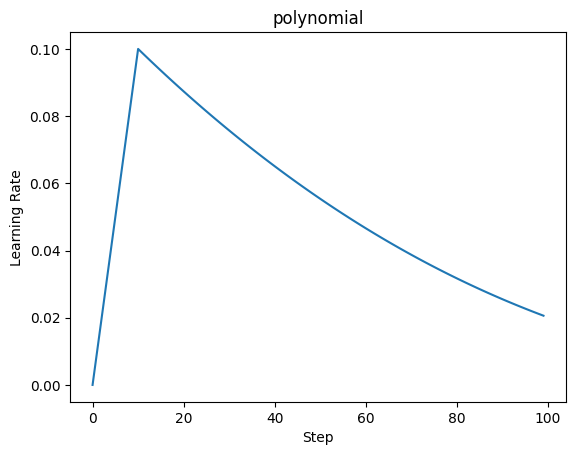

In [4]:

from accelerate import Accelerator

tensor = torch.FloatTensor([[4]]) # build a tensor
x = Variable(tensor, requires_grad=True) # build a variable, usually for compute gradients

scheduler_name = 'polynomial'
scheduler_specific_kwargs = {}
if scheduler_name == 'cosine_with_restarts':
    scheduler_specific_kwargs = {
        'num_cycles': 2,
    }
elif scheduler_name == 'cosine_with_min_lr':
    scheduler_specific_kwargs = {
        'min_lr': 0.1
    }
elif scheduler_name == 'polynomial':
    scheduler_specific_kwargs = {
        'power': 2.5
    }
steps = 100
warmup = 0.1
optimizer2 = torch.optim.Adam([x], lr=0.1)
scheduler2 = get_scheduler(
        name=scheduler_name,
        optimizer=optimizer2,
        num_warmup_steps=int(steps*warmup),
        num_training_steps=steps*2,
        scheduler_specific_kwargs=scheduler_specific_kwargs
)

learning_rates2 = []

for step in range(steps):
    learning_rates2.append(optimizer2.param_groups[0]['lr'])

    optimizer2.zero_grad()
    outputs2 = torch.pow((x - 5), 2)
    loss2 = outputs2
    loss2.backward()
    optimizer2.step()
    scheduler2.step()

print(x)

# Plotting the learning rates
plt.plot(range(steps), learning_rates2)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title(scheduler_name)
plt.show()